In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

In [93]:
nltk.download('stopwords')
nltk.download('punkt')

# Function to preprocess text
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stop_words]
    return ' '.join(words)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [94]:
# Load the dataset
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding='latin-1', names=columns)

# Map target labels to binary values
df['target'] = df['target'].map({0: 0, 4: 1})

# Select a subset for faster computation
df = df.sample(10000, random_state=42)

# Preprocess text data
df['text'] = df['text'].apply(preprocess_text)

# Use TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['text']).toarray()
y = df['target'].values

In [95]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [96]:
# Logistic Regression Model from Scratch
class LogisticRegressionFromScratch:
    def __init__(self, learning_rate=0.005, epochs=3000, regularization=None, lambda_=0.01):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.regularization = regularization
        self.lambda_ = lambda_
        self.weights = None

    def fit(self, X, y):
        self.weights = np.zeros(X.shape[1] + 1)
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        for epoch in range(self.epochs):
            z = np.dot(X, self.weights)
            h = sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size

            # Apply regularization if specified
            if self.regularization == 'l2':
                gradient += self.lambda_ * self.weights / y.size
            elif self.regularization == 'l1':
                gradient += self.lambda_ * np.sign(self.weights) / y.size

            self.weights -= self.learning_rate * gradient

    def predict_proba(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return sigmoid(np.dot(X, self.weights))

    def predict(self, X):
        return self.predict_proba(X) >= 0.5

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [97]:
# Cross-validation
def cross_validation(X, y, k=5):
    kf = KFold(n_splits=k)
    accuracies = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model = LogisticRegressionFromScratch(learning_rate=0.005, epochs=3000, regularization='l2', lambda_=0.01)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        accuracies.append(accuracy)
    
    return np.mean(accuracies)

In [99]:
# Perform cross-validation
cv_accuracy = cross_validation(X_train, y_train)
print(f"Cross-Validation Accuracy: {cv_accuracy * 100:.2f}%")

# Retrain with optimal parameters found from cross-validation
best_model = LogisticRegressionFromScratch(learning_rate=0.005, epochs=9000, regularization='l2', lambda_=0.01)
best_model.fit(X_train, y_train)

Cross-Validation Accuracy: 69.70%


In [100]:
# Predict on test data
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 69.60%


In [101]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       980
           1       0.69      0.74      0.71      1020

    accuracy                           0.70      2000
   macro avg       0.70      0.70      0.69      2000
weighted avg       0.70      0.70      0.70      2000



In [102]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[637 343]
 [265 755]]


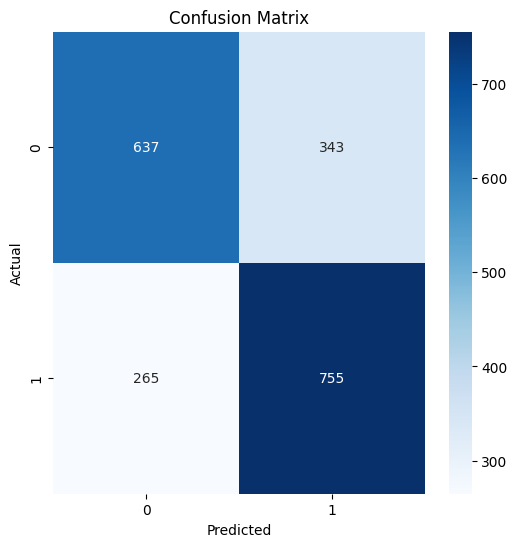

In [103]:
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

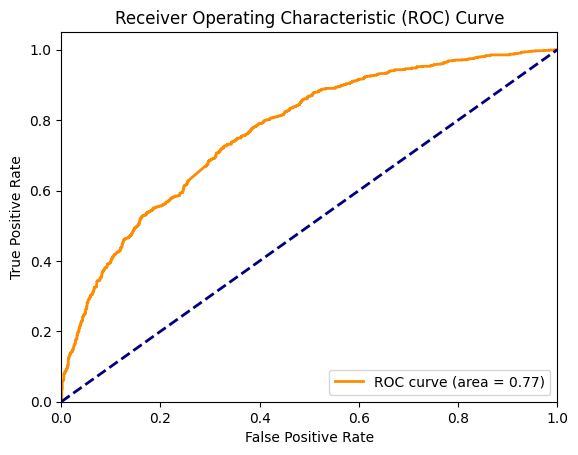

In [104]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

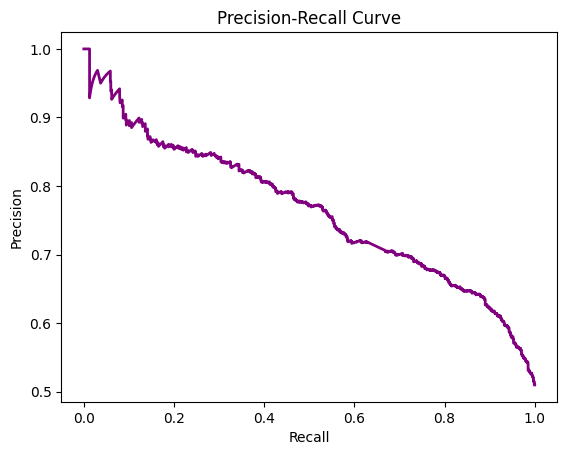

In [105]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure()
plt.plot(recall, precision, lw=2, color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [106]:
# Test the model on real tweets
real_tweets = [
    "I just watched a great movie! Absolutely loved it.",
    "That was the worst movie I've ever seen. Total waste of time.",
    "I'm not sure how I feel about this movie. It was just okay.",
    "The movie was quite boring and too long for my taste.",
    "A total masterpiece... love it."
]

for tweet in real_tweets:
    preprocessed_tweet = preprocess_text(tweet)
    tweet_features = vectorizer.transform([preprocessed_tweet]).toarray()
    tweet_prob = best_model.predict_proba(tweet_features)
    tweet_pred = best_model.predict(tweet_features)
    sentiment = "Positive" if tweet_pred[0] == 1 else "Negative"
    print(f"Original Tweet: {tweet}")
    print(f"Preprocessed Tweet: {preprocessed_tweet}")
    print(f"Tweet Sentiment: {sentiment}")
    print(f"Probability of being positive: {tweet_prob[0]:.2f}\n")

Original Tweet: I just watched a great movie! Absolutely loved it.
Preprocessed Tweet: watched great movie absolutely loved
Tweet Sentiment: Positive
Probability of being positive: 0.50

Original Tweet: That was the worst movie I've ever seen. Total waste of time.
Preprocessed Tweet: worst movie ever seen total waste time
Tweet Sentiment: Negative
Probability of being positive: 0.48

Original Tweet: I'm not sure how I feel about this movie. It was just okay.
Preprocessed Tweet: sure feel movie okay
Tweet Sentiment: Negative
Probability of being positive: 0.48

Original Tweet: The movie was quite boring and too long for my taste.
Preprocessed Tweet: movie quite boring long taste
Tweet Sentiment: Negative
Probability of being positive: 0.47

Original Tweet: A total masterpiece... love it.
Preprocessed Tweet: total masterpiece love
Tweet Sentiment: Positive
Probability of being positive: 0.54

